In [38]:
#MCMC introduction
#Based on PyMC3 docu exmaples 
#Powered by Jan Nagler

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
# set output floats to 5 significant digits throughout the journey
%precision 4 
%matplotlib inline
# Base your life on the meaning of life
np.random.seed(42)

In [39]:
# Model: Simple random additive noise

# Groundtruth parameter values
alpha, sigma = 1, 1 # intercept and std
beta = [1, 2.5] # weights

# Size of surrogate dataset
size = 125

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.3

# Surrogate data set
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

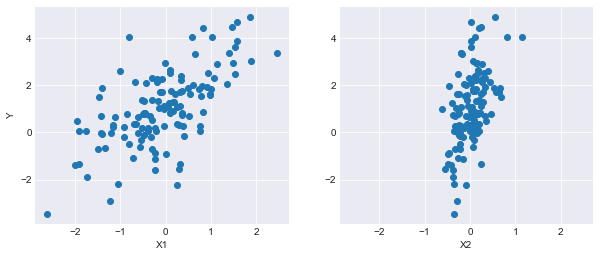

In [40]:
#plot data, projections
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [41]:
# This is a massive lib for MCMC 
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))
# pip install git+https://github.com/pymc-devs/pymc3
# just run this commend in your shell

Running on PyMC3 v3.8


Define prior distributions for the parameters for which we will be trying to infer posterior distributions

In [42]:
# Build a model 
basic_model = pm.Model()

with basic_model: #context manager

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    # Determinitic random variable, means sharply defined by delta function over data and model param
    mu = alpha + beta[0]*X1 + beta[1]*X2 

    # Likelihood (sampling distribution) of observations, given out surrogate data Y
    # Called observed stochastic variable 
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

Perform MCMC: Sample from our prior distribution, simulate the model, and evaluate the likelihood of the data given those input parameters, based on our "basic model", and the "noise" distribution, our (surrogate) data Y. Use Bayesian inference to decide whether to keep the trial points or throw them away. Choose a new set of points and start over.

In [43]:
# MCMC Sampling method 
with basic_model:
    
    # Compute MAP estimate
    start = pm.find_MAP() # args, e.g., model=basic_model, Powell method (no derivatives needed)
    print("Start", start)
    
    # instantiate sampler steps: Optional 
    #step = pm.Slice()
    #step = pm.Metropolis()
    step = pm.NUTS()
    
    # draw 5000 posterior samples
    trace = pm.sample(500, step=step)

Start {'alpha': array(1.0704), 'beta': array([1.1027, 2.7388]), 'sigma_log__': array(-0.1088), 'sigma': array(0.8969)}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.07,0.08,0.92,1.24,0.0,0.0,3516.0,3511.0,3514.0,1656.0,1.0
beta[0],1.10,0.09,0.94,1.26,0.0,0.0,2907.0,2907.0,2928.0,1558.0,1.0
beta[1],2.74,0.28,2.23,3.26,0.0,0.0,2641.0,2572.0,2640.0,1588.0,1.0
sigma,0.92,0.06,0.81,1.04,0.0,0.0,3248.0,3248.0,3135.0,1343.0,1.0


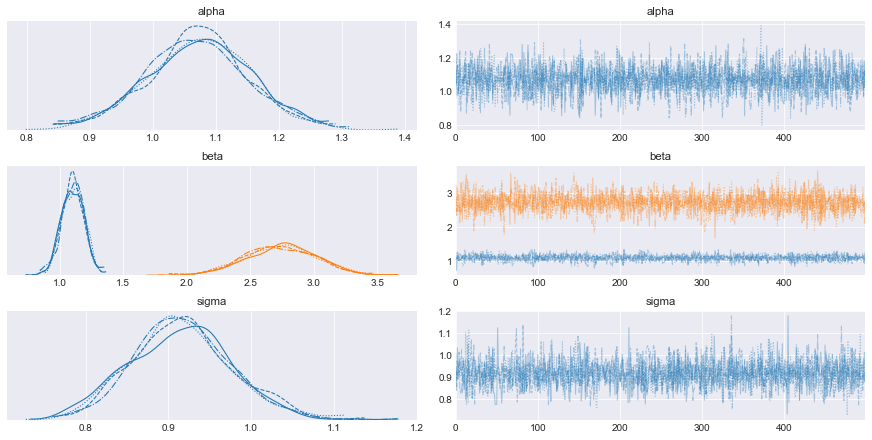

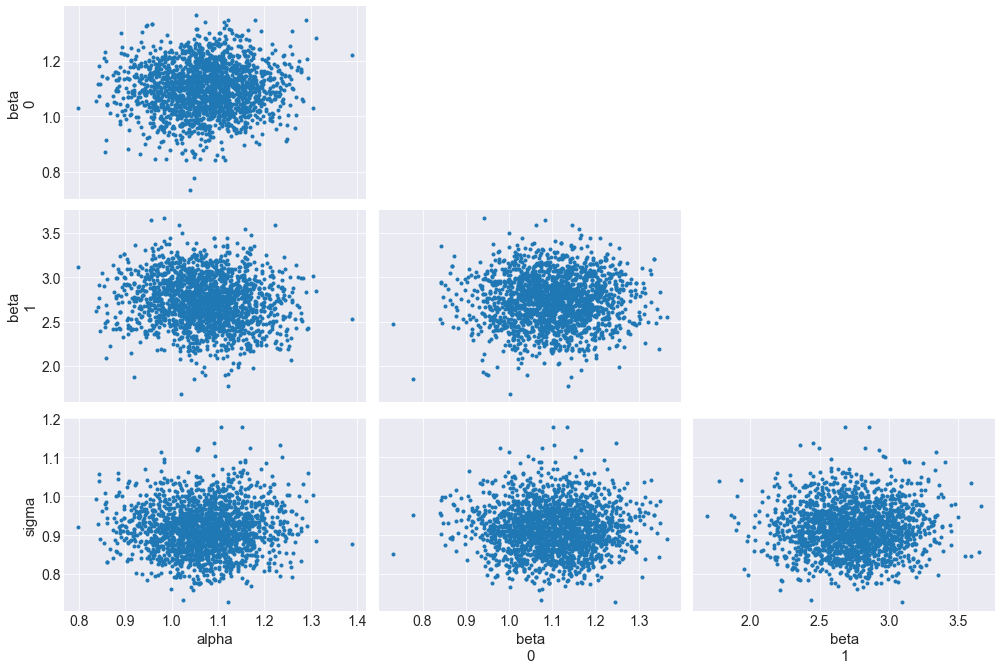

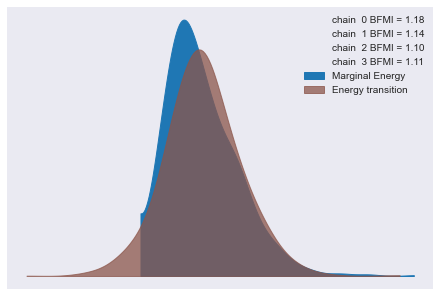

In [44]:
pm.traceplot(trace)
#pm.autocorrplot(trace)
pm.pairplot(trace)
pm.energyplot(trace) # https://arxiv.org/pdf/1604.00695v1.pdf
pm.summary(trace).round(2)

In [45]:
# And now to something completely different

In [46]:
# Sampling using steps that defined the MCMC method 
# Minimal Coin toss example with PyMC3
# compact form

basic_model = pm.Model()

with basic_model:
    
    size = 125
    alpha = 5
    beta = 2
    h = 75 # number of heads observed
    
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta)

    # define likelihood
    y = pm.Binomial('y', n=size, p=p, observed=h)
    
    # Compute MAP estimate
    start = pm.find_MAP()
    
    # instantiate sampler steps: Optional 
    step = pm.Metropolis() # Discrete variables
    
    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.6,0.04,0.53,0.68,0.0,0.0,877.0,872.0,880.0,752.0,1.0


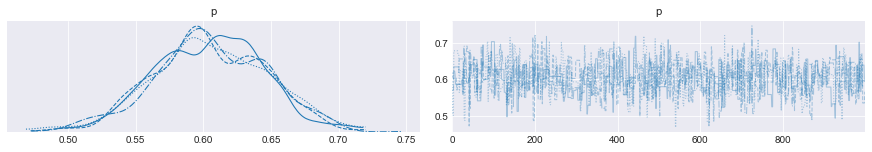

In [47]:
pm.traceplot(trace);
pm.summary(trace).round(2)

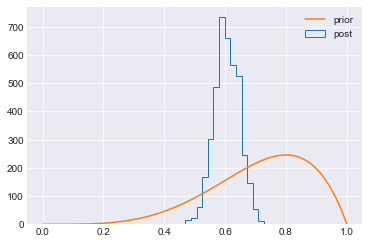

In [48]:
import scipy.stats as stats
plt.hist(trace['p'], 15, label='post', histtype='step')
x = np.linspace(0, 1, 100)
plt.plot(x, 100*stats.beta.pdf(x, alpha, beta), label='prior')
plt.legend(loc='best')